# Harmory creation demo

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import pandas as pd

import constants
from visualisation import plot_univariate_signal, plot_peak_positions_overlay
from create import HarmonicPrint, HarmonicSegmentation

In [15]:
# Hyper-parameters
SR = constants.SR
L_KERNEL = constants.L_KERNEL
VAR_KERNEL = constants.VAR_KERNEL

In [16]:
# First, we neeed to load some data from ChoCo
choco_jams_dir = "../../choco/choco-jams/"

# In this example, we will only load harmonic data from audio music
choco_meta = pd.read_csv(choco_jams_dir + "meta.csv")
choco_meta = choco_meta[choco_meta["type"] == "audio"]
jams_rpaths = list(choco_jams_dir + "jams/" + choco_meta["id"] + ".jams")

print(f"Using {len(jams_rpaths)} harmonic progressions in this example.")
sample_jams = jams_rpaths[62]
print(f"Selecting sample: {sample_jams}")

Using 2283 harmonic progressions in this example.
Selecting sample: ../../choco/choco-jams/jams/billboard_154.jams


(<Figure size 1500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'TPS Time Series'}, ylabel='TPS distance'>)

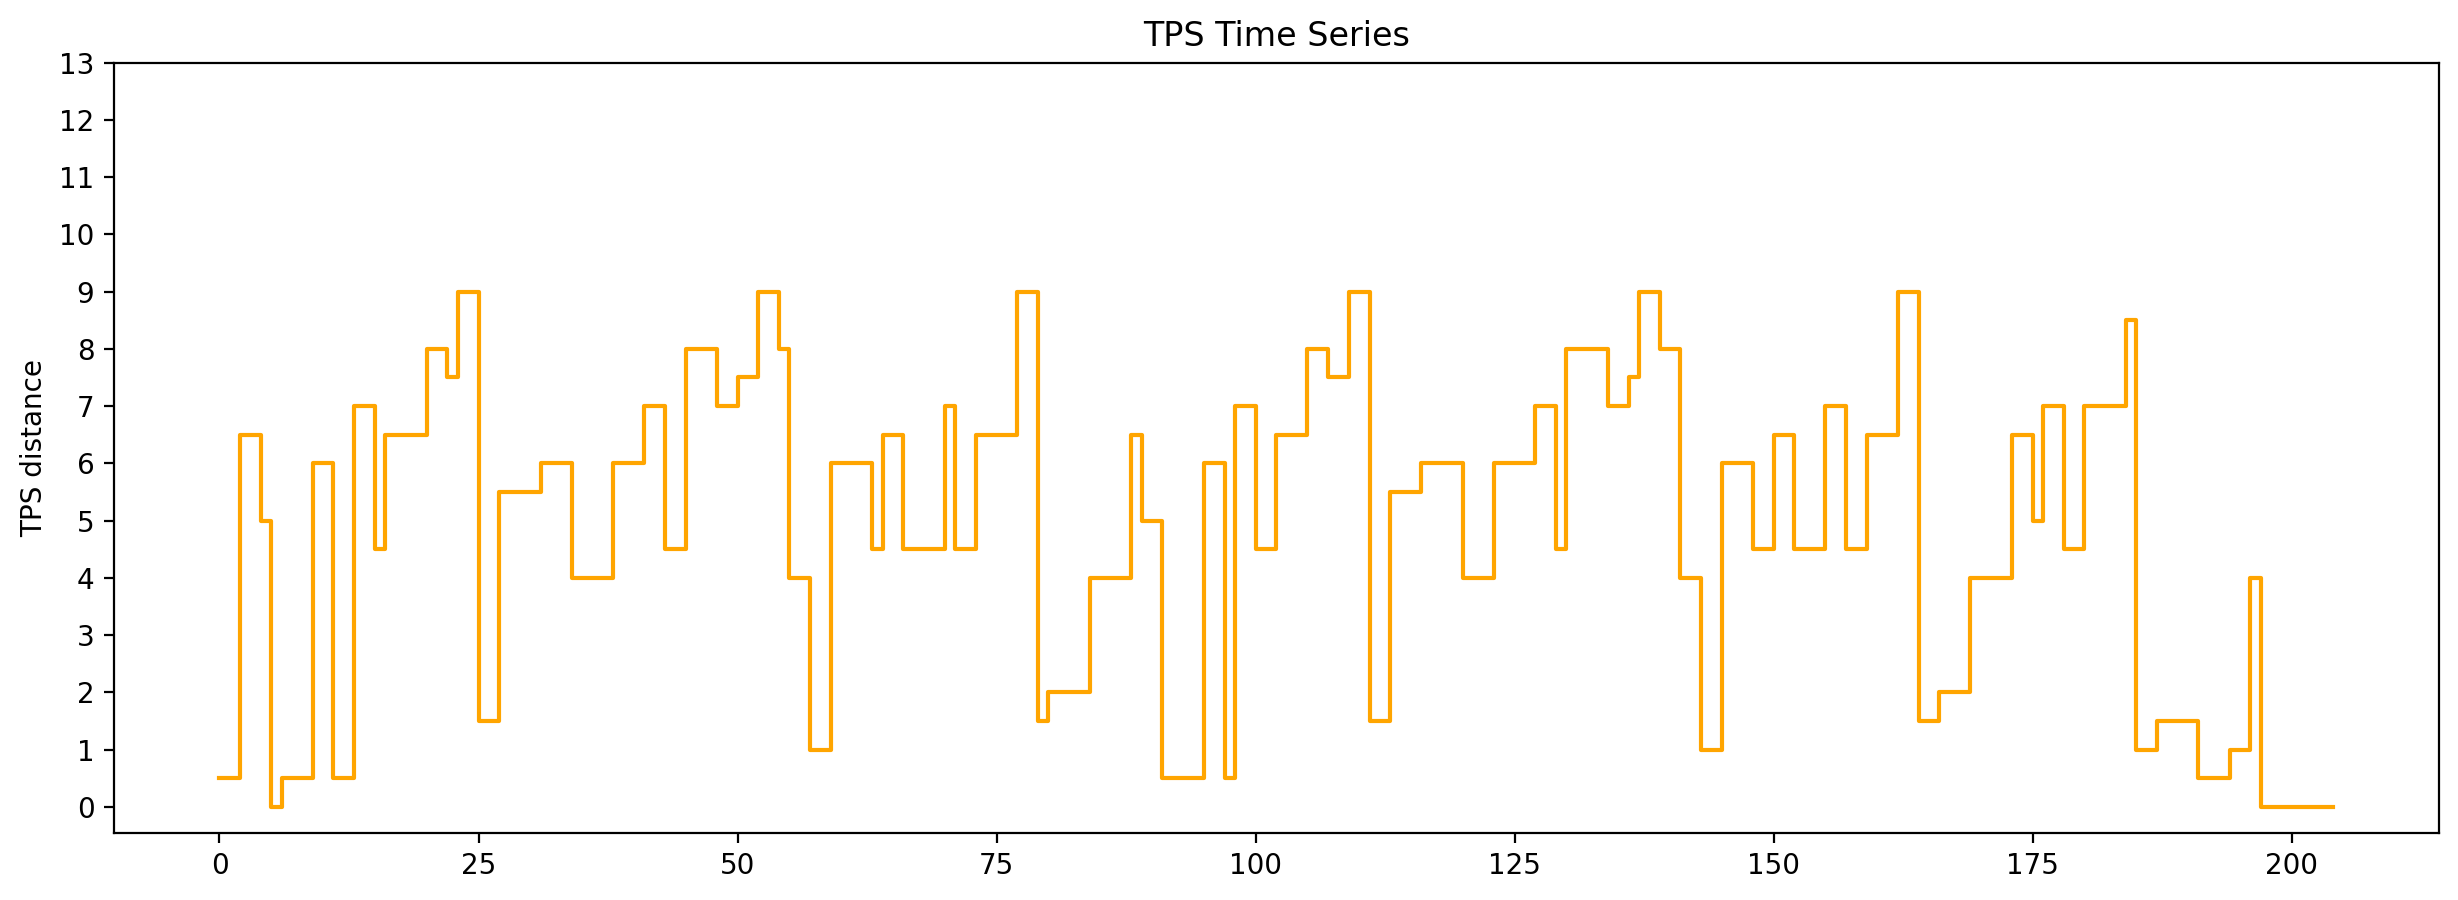

In [17]:
hprint = HarmonicPrint(sample_jams, sr=SR)

hprint.tps_timeseries.plot_time_series()

(<Figure size 1080x144 with 1 Axes>,
 <AxesSubplot:xlabel='Time (seconds)'>,
 [<matplotlib.lines.Line2D at 0x7fd9cc4b0e20>])

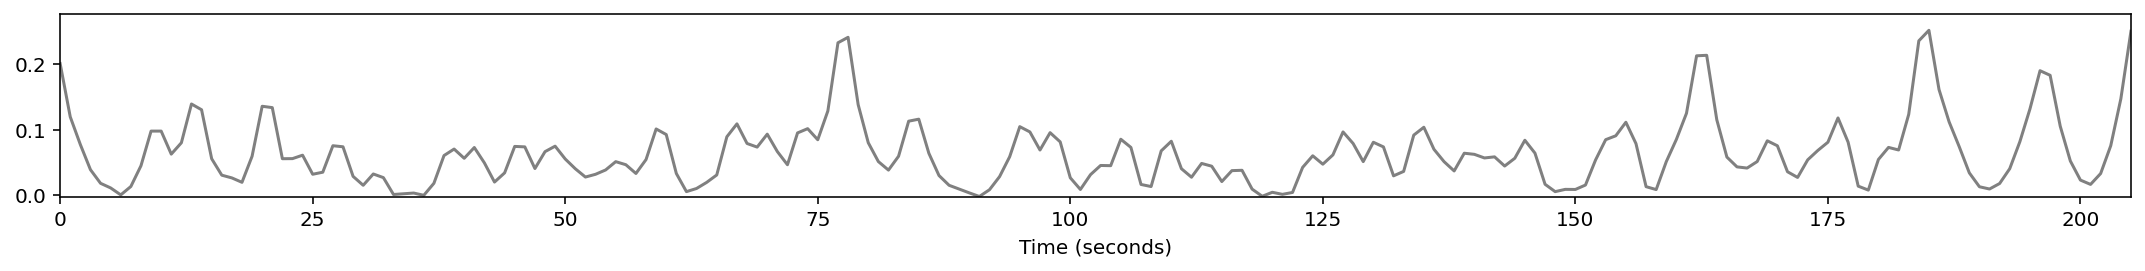

In [41]:
segmenter = HarmonicSegmentation(hprint)
novelty = segmenter.compute_novelty_curve(l=8, var=VAR_KERNEL)
plot_univariate_signal(novelty, sr=SR, figsize=(15,2))

(<Figure size 1080x144 with 1 Axes>, <AxesSubplot:xlabel='Time (seconds)'>)

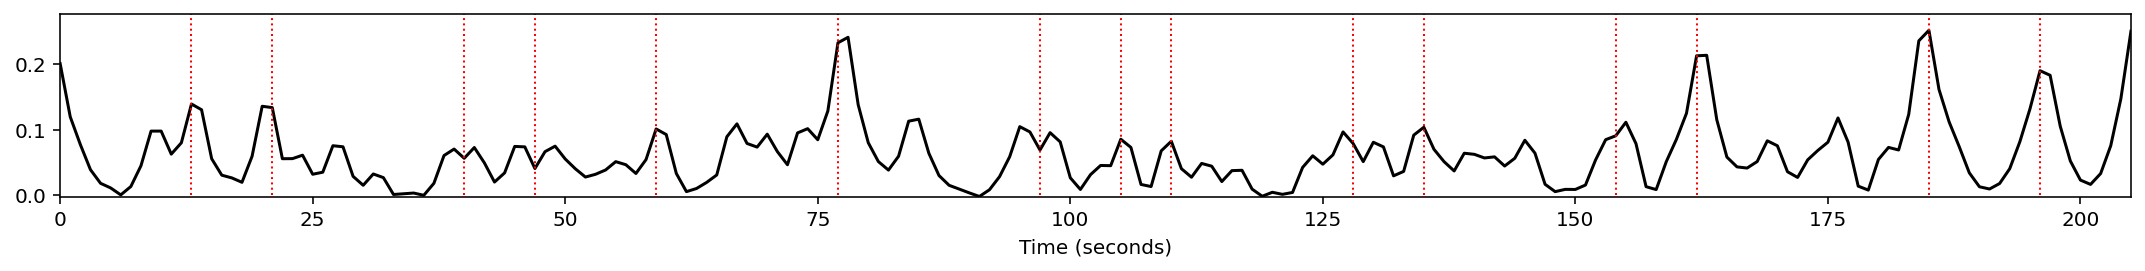

In [42]:
peaks, pdout = segmenter.detect_peaks("msaf", median_len=24, sigma=2)

plot_peak_positions_overlay(novelty, sr_x=1, peaks=peaks, figsize=(15,2))

In [59]:
hstructures = segmenter.segment_harmonic_print()
segmenter.dump_harmonic_segments("../data/")

In [63]:
choco_jams_dir

'../../choco/choco-jams/'

In [67]:
import os
import glob
import tqdm
from joblib import Parallel, delayed


example_config = {
    "sr": constants.SR,
    "l_kernel": constants.L_KERNEL,
    "var_kernel": constants.VAR_KERNEL,
    "tpst_type": "offset",
    "pdetection_method": "msaf",
    "pdetection_params": dict(median_len=24, sigma=2)
}

out_dir = "../data/structures/"
bb_jams = glob.glob(choco_jams_dir + "jams/billboard_*.jams")
len(bb_jams)

890

In [68]:
def segmentation_fn(jams_path, config):

    hprint = HarmonicPrint(jams_path, config["sr"], config["tpst_type"])
    hprint.chord_ssm  # this will init internal structures
    hprint._tps_timeseries  # this will init internal structures

    segmenter = HarmonicSegmentation(hprint)

    segmenter.run(
        l_kernel=config["l_kernel"],
        var_kernel=config["var_kernel"],
        pdetection_method=config["pdetection_method"],
        **config["pdetection_params"])

    segmenter.dump_harmonic_segments(out_dir)

In [71]:
segmentation_fn(bb_jams[100], config=example_config)

In [72]:
!ls ../data/structures/

billboard_517.pickle


In [ ]:
with open('../data/samples/billboard small.txt') as f:
    lines = f.read().splitlines()